# Crypto Currency Portfolio Tracker

In this project we aim to build a crytpo portfolio tracker, dashboard and analytics web app. We'll be using the coingecko API in the first instance to call in the data and then we'll use streamlit and heroku to deploy an application to the web for user interface and on the go tracking. 

This notebook will act as the master notebook for the main project functions, interfaces and testing.

In [2]:
# Import libraries and coingecko
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np

import datetime
import time

import warnings
warnings.filterwarnings("ignore")

In [3]:
import pickle

In [22]:
plt.style.use("fivethirtyeight")

In [23]:
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

## API CALL
First we'll write the function that calls in the coingecko api

In [67]:
def api_call(port_list):
    
    """
    In this function we'll execute the following tasks
    1. Take a list of crypto currencies provided by the user and call in the coin's history and other data from 
    coingecko.
    2. Store the information in a portfolio dictionary
    3. Return the dictionary for investigation and storage elsewhere
    
    """
    
    # we only want the set of tokens in the port_list
    port_set = list(set(port_list))
    
    port_dict = {}

    for i in range(len(port_set)):

        # Create a master key, which will be equal to the name of the token
        master_key = port_set[i]

        # Set our sub keys which is the description of every piece of info we'll hold on a token
        sub_keys = ["ticker", "quote", "price_history"]

        # Set an empty values list that will hold the called in information
        values = []



        # Call in the history, access the ticker and append to the values list
        history = cg.get_coin_history_by_id(id=port_set[i], vs_currencies='usd', date='30-12-2020')
        ticker = history["symbol"]
        values.append(ticker)

        # Call in the quote and append to the values
        quote = cg.get_price(ids=port_set[i], vs_currencies='usd')[port_set[i]]["usd"]
        values.append(quote)

        # Call in the chart 
        chart = cg.get_coin_market_chart_by_id(id=port_set[i], vs_currency='usd', days=90)

        # Create a token dictionary on every iteration, store our key value pairs including prices
        token_dict = {master_key : {sub_keys[0]: values[0], sub_keys[1]: values[1], sub_keys[2]: chart}}

        # Add the token dictionary to the master portfolio dictionary
        port_dict.update(token_dict)

        # Print to see progress through api calls - seems slow
        print(i)

        # Wait a few seconds between each iteration, help the api as url timing out and api sluggish
        time.sleep(30)
    
    return port_dict


## User Setup
We'll now construct a function that will act as the user profile setup. Here we'll ask the user which cryptos they hold, how much they hold and transaction details. 

In [68]:
def user_setup():
    
    """
    In this function we will set up the initial user portfolio, we'll ask the following questions and store their coin
    portfolio which will include the coin name, historical price data, ticker and portfolio history:
    Questions / Actions
    1. Ask user which coins they hold, add each coin to a list
    2. Ask the user the date of the purchase, add each transaction date to a list
    3. Ask how many of each coin was purchased, add each quantity to a list
    4. Pass the list of coins as an argument to the api_call function to allow all data to be called in.
    
    Once the user has added all coins in their portfolio we can exit the set up and return the portfolio data as a 
    dictionary alongside a transaction history stored as a dataframe
    """
    
    # First we'll create a suite of empty lists to store each coin's data
    port_list = []
    purchase_dates = []
    cost_list = []
    qty_list = []
    
    # We will assume a user has more coins to add to their portfolio unless they express otherwise
    more_coins = "yes"
    
    # We need to know the full set of available coins in the coingecko database
    coins_list = cg.get_coins_list()
    # We'll be searching by coin ids so let's store the coin ids in a list
    ids = [item["id"] for item in coins_list]
    
    
    # Create the user setup interface
    for i in range(100): # Let's assume no-one with more than 100 coins in their portfolio(make a note on the webpage)
        
        # Assume how user wants to add coins to his portfolio at this setup stage
        if more_coins == "yes":

            # Ask the user for the name of a coin they wish to add to their portfolio
            coin_name = input("Type in the name of a coin in your portfolio: ") # eth, vet, btc etc etc
            
            # Check user has entered a valid coin id, if not, ask the user to retry

            while coin_name:
                if coin_name in ids: # Does the coin exist in the set of all available coins?
                    print(coin_name)
                    break
                else:
                    coin_name = input("That coin has not been found, please try again. Refer to catalogue for \
                    full list of cryto ids")
            
            # Ask the user the date on which the coin was purchased
            date = input("What was the purchase date:(yyyy-mm-dd) ") # 2020-10-23
            
            # Check the user has entered a valid date, otherwise ask for a re-entry
            date_format = "%Y-%m-%d"
            while date:
                try:
                    datetime.datetime.strptime(date, date_format)
                    print("This is the correct date format")
                    break
                except ValueError:
                    print("Please enter a valid date in yyyy-mm-dd format")
                    date= input("date")

            
            
            
            cost = float(input("What was the purchase cost:(USD) ")) # 250
            quantity = float(input("How many of this coin did you buy: ")) # 1500.0 will be stored as a float
            
        


            # Append the details to the relevant lists, note we should append None where no answer given
            port_list.append(coin_name)
            purchase_dates.append(date)
            cost_list.append(cost)
            qty_list.append(quantity)
                
        
            
        # Ask the user if they have anymore coins to add to the portfolio
            
        more = input("Do you have anymore coins to add to your portfolio? y/n ")
        
        # Check the user has entered a valid request - if not redirect them to re-enter
        while more:
            if more.lower() == 'y' or more.lower() == "yes":
                break
            elif more.lower() =='n' or more.lower() == "no":
                break
            else:
                more = input("Please enter 'y' or 'n' to continue")
        
        # If we have more coins to add to the portfolio then bo back to question 1 (coin_name)
        if more.lower() == "y" or more.lower() == "yes":
            continue
        else:
            break
    print(port_list)
    
    ## Call the api based on the port list
    portfolio = api_call(port_list) # Bear in mind the api will want only unique values from our port_list
    
    # Create a purchase history from our lists at top of page
    transaction_history = pd.DataFrame()
    
    transaction_history["name"] = port_list
    transaction_history["date"] = purchase_dates ### This needs to be switched to datetime format
    transaction_history["cost"] = cost_list
    transaction_history["quantity"] = qty_list
    
    
    
    
    return portfolio, transaction_history
        

In [71]:
# Call the user setup to build our portfolio

portfolio, transactions = user_setup()

Type in the name of a coin in your portfolio: bitcoin
bitcoin
What was the purchase date:(yyyy-mm-dd) 2021-01-16
This is the correct date format
What was the purchase cost:(USD) 1000
How many of this coin did you buy: 0.3
Do you have anymore coins to add to your portfolio? y/n y
Type in the name of a coin in your portfolio: ethereum
ethereum
What was the purchase date:(yyyy-mm-dd) 2021-02-20
This is the correct date format
What was the purchase cost:(USD) 2000
How many of this coin did you buy: 1.2
Do you have anymore coins to add to your portfolio? y/n y
Type in the name of a coin in your portfolio: vechain
vechain
What was the purchase date:(yyyy-mm-dd) 2021-01-10
This is the correct date format
What was the purchase cost:(USD) 400
How many of this coin did you buy: 3000
Do you have anymore coins to add to your portfolio? y/n y
Type in the name of a coin in your portfolio: maker
maker
What was the purchase date:(yyyy-mm-dd) 2021-03-06
This is the correct date format
What was the purc

In [72]:
portfolio.keys()

dict_keys(['bitcoin', 'maker', 'ethereum', 'vechain'])

In [73]:
# Check the transactions
transactions

,name,date,cost,quantity
0,bitcoin,2021-01-16,1000.0,0.3
1,ethereum,2021-02-20,2000.0,1.2
2,vechain,2021-01-10,400.0,3000.0
3,maker,2021-03-06,500.0,0.8


In [75]:
portfolio["maker"]["ticker"]

'mkr'

In [76]:
import pickle

# let's save this portfolio to file
user_portfolio = open("my_portfolio.pkl", "wb")
pickle.dump(portfolio, user_portfolio)
user_portfolio.close()

In [77]:
# Also save the transactions to file as we'll possibly need access to this too
user_transactions = open("my_transactions.pkl", "wb")
pickle.dump(transactions, user_transactions)
user_transactions.close()

In [78]:
# let's check this can be read back in ok
user_portfolio = open("my_portfolio.pkl", "rb")
load_port = pickle.load(user_portfolio)

In [80]:
user_transactions = open("my_transactions.pkl", "rb")
load_transactions = pickle.load(user_transactions)

In [79]:
load_port.keys()

dict_keys(['bitcoin', 'maker', 'ethereum', 'vechain'])

In [81]:
load_transactions

,name,date,cost,quantity
0,bitcoin,2021-01-16,1000.0,0.3
1,ethereum,2021-02-20,2000.0,1.2
2,vechain,2021-01-10,400.0,3000.0
3,maker,2021-03-06,500.0,0.8


In [122]:
transactions[transactions.name=="vechain"].iloc[0].date

'2021-01-10'

In [82]:
# Let's get the last bitcoin price to check nothing has been lost in the save/load process
load_port["bitcoin"]["price_history"]["prices"][-1] # ~54900 - OK!

[1620202026000, 54952.840484952074]

## User Terminal and Performance / Analysis

The next section concentrates on matters post set up. So a user has a portfolio full of healthy coins and respective data. Now the user will want to review each coin's performance and pull up performance metrics and analysis.

In [4]:
load_port = open("my_portfolio.pkl", "rb")
portfolio = pickle.load(load_port)

In [10]:
list(portfolio.keys())

['bitcoin', 'maker', 'ethereum', 'vechain']

### Performance

In [141]:
def performance(data, timeframe, transactions, analysis):
    
    """
    This function calculates the performance of the requested crytpo currency
    1. We calculate the coin growth as a percent
    2. Over a time frame specified by the user (to be added)
    
    We return the growth as a %age and a dataframe of prices for the specified period
    
    transactions = the full transactions dataframe
    data = the available price data for the requested coin
    timeframe = the requested timeframe from the user
    """
    
    # First get todays date and the current month
    now_date = datetime.date.today().strftime("%Y-%m-%d")
    now_month=now_date[5:7] # split out the month from the date
    start_date='' # set an empty string to hold the start date
    
    
    
    if timeframe == "30d":
    # For monthly queries we'll get the last 30days data
        start_date = str(datetime.datetime.now() - datetime.timedelta(days=30))[:10] # slice to get date only
    elif timeframe == "90d":
    # For quarterly we'll get the last 90days
        start_date = str(datetime.datetime.now() - datetime.timedelta(days=90))[:10]
    elif timeframe == "portfolio":
        start_date = transactions[transactions.name=="vechain"].iloc[0].date
        
        

    # Query the latest monthly data using today's date and the previous 30days
    monthly_data = data[data["date"].between(start_date, now_date)]
    
    # set the open and close prices subject to the calculation
    open_monthly = monthly_data.price[0]
    close_monthly = monthly_data.price[-1]
    
    # Set a variable to hold the growth figure
    percent_chg = 0
    
    # Calculate the growth depending on whether we have -ve or +ve growth for the period
    if open_monthly > close_monthly:
        percent_chg = -round(100 - ((100/open_monthly) * close_monthly), 2)
    elif open_monthly < close_monthly:
        percent_chg = round(((100/open_monthly) * close_monthly)-100, 2)
    else: 
        percent_chg = 0
      
    # Return the growth figure and a dataframe for the period
    return percent_chg, monthly_data

## Coin Data
Next we need to get the requested coin into dataframe format for easy querying and analysis etc

In [142]:
def coin_data(portfolio, user_request):
    
    """
    This function builds a dataframe of data for the requested coin... this has room for simplification
    """
    
    
    
    ## We'll start basic - what percent is the investment up for the month 
    
    data = portfolio[user_request]["price_history"]
    #data.keys()
    
    # Extract metrics from the data
    price = data["prices"]
    mkt_cap = data["market_caps"]
    volume = data["total_volumes"]

    # Save the individual metrics to variables
    times = [item[0] for item in price]
    prices = [item[1] for item in price]
    mkt_caps = [item[1] for item in mkt_cap]
    vols = [item[1] for item in volume]
    
    # Create the dataframe and populate the features
    coin_df = pd.DataFrame(columns=["time", "price", "market_cap", "volume"])
    coin_df.time = times
    coin_df.price = prices
    coin_df.market_cap = mkt_caps
    coin_df.volume = vols

    # Change the time format to datetime and set it as the index
    coin_df.time = pd.to_datetime(coin_df.time, unit="ms")
    coin_df.set_index("time", inplace=True)
    
    # Create a date feature that holds only the date
    coin_df["date"] = pd.to_datetime(coin_df.index)
    coin_df["date"] = pd.to_datetime(coin_df.date).dt.date
    coin_df.date = pd.to_datetime(coin_df.date)
    
    # We've created the dataframe for the specific coin - now we want to know the %age change for the month
    
    # percent_chg = performance(coin_df)

    

    
    return coin_df, user_request
    

### Terminal
Now we build a terminal for the user to request the data and metrics on a specific coin for a specific time frame

In [149]:
def terminal(portfolio, transactions):
    
    """
    In this function we will use the data previously stored thro' the user setup and ask the user what they would 
    like to look at
    1. Overall portfolio performance - call to another function 
    2. A specific coin performance - call to another function
    """
    hodling = list(portfolio.keys())
    analysis = input("What would you like to look at? Enter a coin name such as 'bitcoin' or type 'overall' ")
    ### Need to add in a loop for invalid inputs - drop down menus on app?
    
    while analysis:
        if analysis in hodling:
            # We're good - you have that coin in your portfolio
            break
        else:
            # We bad, you have entered an invalid coin - either a typo or you don't hodl it! 
            analysis = input("ERROR: You do not hodl that coin, please enter the name of a coin that you\
            hodl in your portfolio")
        
    
    ## This should be a drop down menu - #### Currently this question does not affect the output
    timeframe = input("What timeframe would you like to review performance over? Enter 30d, 90d, portfolio")
    
    while timeframe:
        if timeframe == "30d" or timeframe == "90d" or timeframe == "portfolio":
            # Accepted entries! we can move on
            break
        else:
            timeframe = input("You have entered an invalid timeframe, please enter 30d, 90d or portfolio\
            to continue")
    
    
    # We pass the portfolio created in user setup and then the name of the coin the user has asked to look at
    #### OVERALL to be added - Only works for individual coins ####
    df, coin = coin_data(portfolio, analysis)
    
    percent_change, timeframe_data = performance(df, timeframe, transactions, analysis)
    
    if timeframe == "30d":
        print(f'{coin} has had a {percent_change}% change this month!')
    elif timeframe == "90d":
        print(f'{coin} has had a {percent_change}% change this quarter!')
    elif timeframe == "portfolio":
        print(f'{coin} has had a {percent_change}% change since investment!')
    
    
    # Plot out the requested coin price and time period
    # plot the growth in the given time period
    fig, ax = plt.subplots(figsize=(12,7))
    #plt.figure(figsize=(12,7))
    if timeframe_data.price.iloc[-1] > timeframe_data.price.iloc[0]:
        ax.plot(timeframe_data.price, label=coin.capitalize()+" price", color="b")
    else:
        ax.plot(timeframe_data.price, label=coin.capitalize()+" price", color="r")
    
    ax.set_title(coin.capitalize()+" price for current " + timeframe + " period")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price(USD)")
    #plt.xticks(rotation=45)
    fig.autofmt_xdate()
    plt.legend();

    return df, coin, percent_change, timeframe_data
    

What would you like to look at? Enter a coin name such as 'bitcoin' or type 'overall' ethereum
What timeframe would you like to review performance over? Enter 30d, 90d, portfolioportfolio
ethereum has had a 105.23% change since investment!


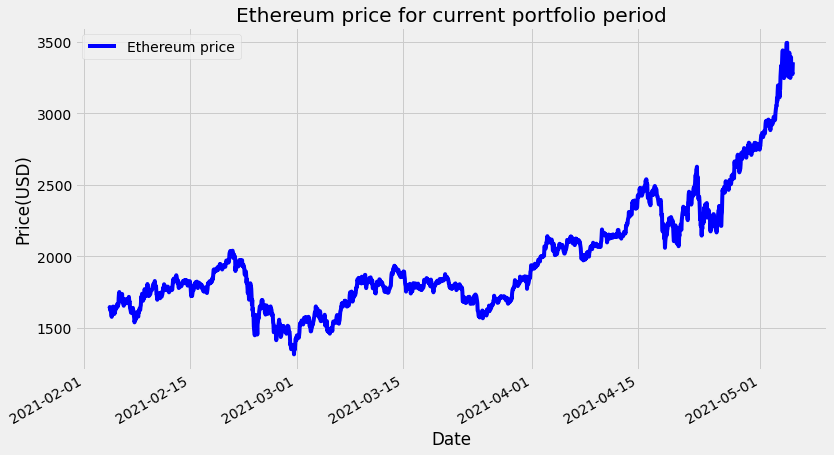

In [150]:
data, coin_name, growth, monthly_data = terminal(portfolio, transactions)

In [74]:
# Check the portfolio has been constructed correctly
portfolio.keys()

dict_keys(['bitcoin', 'maker', 'ethereum', 'vechain'])

In [24]:
monthly_data

,price,market_cap,volume,date
time,,,,
2021-04-01 00:01:56.016,0.598147,3.329832e+08,2.696467e+06,2021-04-01
2021-04-01 01:11:00.676,0.586732,3.236048e+08,2.843161e+06,2021-04-01
2021-04-01 02:28:05.728,0.590454,3.259227e+08,2.798080e+06,2021-04-01
2021-04-01 03:19:42.205,0.587207,3.240970e+08,2.819015e+06,2021-04-01
2021-04-01 04:18:31.641,0.586669,3.235282e+08,2.740685e+06,2021-04-01
...,...,...,...,...
2021-04-27 05:13:40.945,0.465975,2.601670e+08,2.417981e+06,2021-04-27
2021-04-27 06:12:32.713,0.467762,2.587888e+08,2.410985e+06,2021-04-27
2021-04-27 07:11:51.998,0.476950,2.634273e+08,2.535400e+06,2021-04-27


In [35]:
coin_df, user_request = coin_data(portfolio, "maker")

In [36]:
coin_df

,price,market_cap,volume,date
time,,,,
2021-01-27 09:19:52.244,1359.213580,1.234087e+09,1.400812e+08,2021-01-27
2021-01-27 09:47:14.003,1353.132211,1.218654e+09,1.403934e+08,2021-01-27
2021-01-27 10:24:22.950,1351.313784,1.219068e+09,1.393702e+08,2021-01-27
2021-01-27 11:04:32.489,1353.372249,1.221330e+09,1.388727e+08,2021-01-27
2021-01-27 12:05:16.739,1334.780808,1.223145e+09,1.377057e+08,2021-01-27
...,...,...,...,...
2021-04-28 18:01:58.000,4490.679152,4.058335e+09,3.242839e+08,2021-04-28
2021-04-28 18:08:26.000,4509.032355,4.074392e+09,3.255389e+08,2021-04-28
2021-04-28 18:13:26.000,4512.287051,4.065213e+09,3.262244e+08,2021-04-28


In [37]:
user_request

'maker'

In [38]:
now_date = datetime.date.today().strftime("%Y-%m-%d")

In [39]:
now_date

'2021-05-04'

In [44]:
monthly_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 0 entries
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   price       0 non-null      float64       
 1   market_cap  0 non-null      float64       
 2   volume      0 non-null      float64       
 3   date        0 non-null      datetime64[ns]
dtypes: datetime64[ns](1), float64(3)
memory usage: 80.0 bytes


In [49]:
str(datetime.datetime.now())[:10]

'2021-05-04'

In [54]:
start_date = str(datetime.datetime.now() - datetime.timedelta(days=30))[:10]

In [55]:
now_month=now_date[5:7] # split out the month from the date

# Query the latest monthly data using today's date and the current month
monthly_data = coin_df[coin_df["date"].between(start_date, now_date)]

In [140]:
list(portfolio.keys())

['bitcoin', 'maker', 'ethereum', 'vechain']